In [5]:
import pandas as pd #датафреймы
import numpy as np #массивы, линейная алгебра
import pylab as pl #графики
import matplotlib as mpl #графики
%matplotlib inline
%pylab inline
import seaborn as sns #красивые графики!
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [6]:
#prepare data
df=pd.read_csv('OUT_1.csv', index_col=False, header =0)
del df['Geomomentum']

In [7]:
#round "seconds" so that they are float (it's okay as timedeltas will be much bigger) and delete rows with seconds=60.
import math
df.Second=df.Second.astype(int)
df.drop(df.loc[df.Second==60].index, inplace=True)

In [8]:
#We get dates and timedeltas, then convert them to logarithmic scale
import datetime
df.string=df.Year.astype(str)+'-'+df.Month.astype(str)+'-'+df.Day.astype(str)+' '+df.Hour.astype(str)+':'+df.Minute.astype(str)+':'+df.Second.astype(str)

In [9]:
df['Date']=pd.to_datetime(df.string)

In [10]:
df['t']=df['Date'].diff().fillna(0)

In [11]:
df['logtime']=df.t / np.timedelta64(1, 's')

In [12]:
#We delete rows with timedelta=0 to avoid problems with log.
df.drop(df.loc[df.logtime==0].index, inplace=True)

In [13]:
df.logtime=df.logtime.apply(lambda x: math.log(x))

In [14]:
del df['Year']
del df['Month']
del df['Day']
del df['Hour']
del df['Minute']
del df['Second']

### Scripts

In [15]:
#def frameEDF(sample,numbin,edge1=sample.min(), edge2=sample.max()):
def frameEDF(sample,numbin, edge1, edge2):
    num=numbin
    F=[0 for i in range(num)]
    width=(edge2-edge1)/(num-1)
    xedges=[edge1+(i)*width for i in range(num)]
    for i in range(num):
        #F[i]=len(sample.loc[((sample <= xedges[i]) &(sample > xedges[i-1]))])
        F[i]=len(sample.loc[sample <= xedges[i]])/float(len(sample))
    return xedges,F,width
def distance(xedges1,F1,xedges2,F2):
    F=[0 for i in range(len(F1))]
    for i in range(len(F1)):
        F[i]=abs(F1[i]-F2[i])
    return max(F)

In [16]:
def distanceplot(sample,window,bins):
    length=len(sample)-2*window
    dist=[0 for i in range(length)]
    for i in range(length):
        edge1=sample[i:i+2*window].min()
        edge2=sample[i:i+2*window].max()
        xedges1,F1,width1=frameEDF(sample[i:i+window],bins,edge1,edge2)
        xedges2,F2,width2=frameEDF(sample[i+window:i+2*window],bins,edge1,edge2)
        dist[i]=distance(xedges1,F1,xedges2,F2)
    return dist

In [17]:
def shiftEDFplot(sample, win, bins):
    num = len(sample)-win
    xedges=[0 for i in range(num)]
    yedges = [[0 for i in range(bins+1)] for j in range(num)]
    F=[0 for i in range(num)]
    width=[0 for i in range(num)]

    for i in range(num):
        #print i
        #print df.Depth[i:i+win]
        xedges[i],F[i],width[i]=frameEDF(sample[i:i+win],bins,sample[i:i+win].min(),sample[i:i+win].max())
        yedges[i]=[i for j in range(len(xedges[i]))]
        #plt.bar(xedges[i],F[i],width[i])
    #print xedges, len(xedges), len(xedges[1])
    #print yedges
    #print F
    xpos=np.array(xedges[0])
    ypos=np.array(yedges[0])
    zpos=np.array(F[0])
    for i in range(1,len(xedges)):
        xpos=np.append(xpos,xedges[i])
        ypos=np.append(ypos,yedges[i])
        zpos=np.append(zpos,F[i])
    return xpos,ypos,zpos

In [42]:
def stat_index(sample, window,bins):
    kolm_index=0.18+(window-100)*(-0.04)/100.
    print window, kolm_index
    ar = pd.Series.from_array(distanceplot(sample,window,window))
    xedges,F,width=frameEDF(ar,bins, ar.min(),ar.max())
    plt.bar(xedges,F,width)
    x = np.linspace(0, ar.max(), bins)
    y = 1 - x
    plt.plot(x,y,'-')
    for i in range(len(xedges)):
        if((1-xedges[i])<F[i]):
#            print i,xedges[i]+width*0.5,F[i]
            print xedges[i]
            return (xedges[i])/kolm_index

## Distribution plot

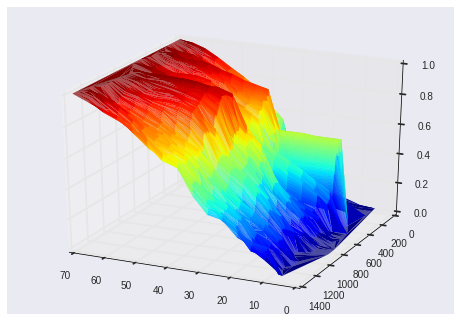

In [19]:
xpos,ypos,zpos=shiftEDFplot(df.Depth,100,15)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(xpos, ypos, zpos,cmap=plt.cm.jet,linewidth=0)
ax.view_init(elev=25., azim=115)

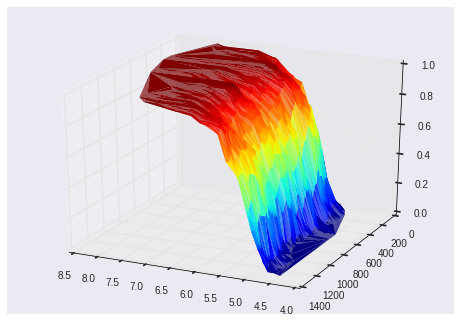

In [20]:
xpos,ypos,zpos=shiftEDFplot(df.Magnitude,100,15)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(xpos, ypos, zpos,cmap=plt.cm.jet,linewidth=0)
ax.view_init(elev=25., azim=115)

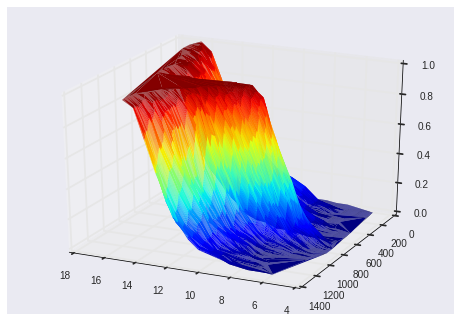

In [21]:
xpos,ypos,zpos=shiftEDFplot(df.logtime,100,15)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(xpos, ypos, zpos,cmap=plt.cm.jet,linewidth=0)
ax.view_init(elev=25., azim=115)

### Depth

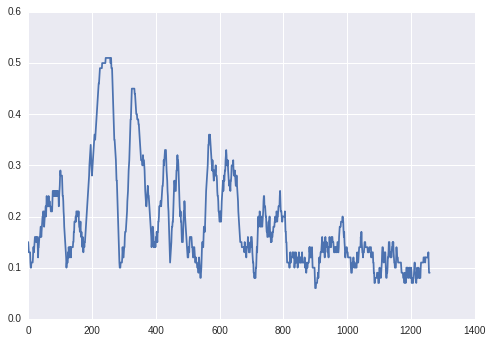

In [22]:
plt.plot(distanceplot(df.Depth,100,100))

### Magnitude

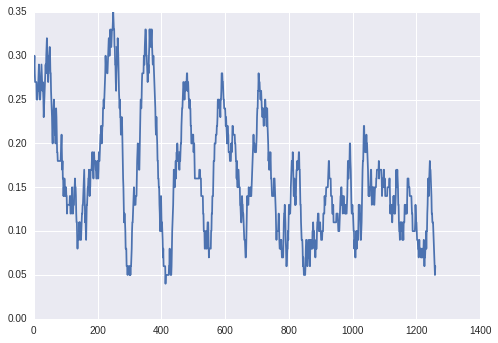

In [23]:
plt.plot(distanceplot(df.Magnitude,100,100))

### Log time

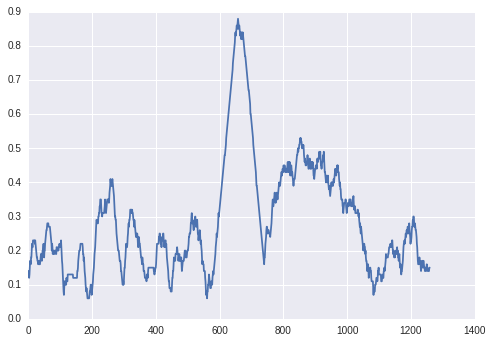

In [24]:
plt.plot(distanceplot(df.logtime,100,100))

# Stationarity index

In [38]:
frame=100

100 0.18
0.241818181818
1.34343434343


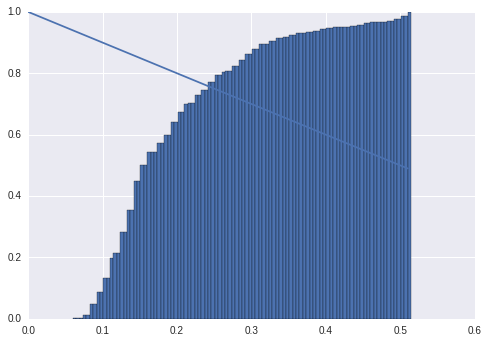

In [43]:
print stat_index(df.Depth,frame,frame)

100 0.18
0.221616161616
1.23120089787


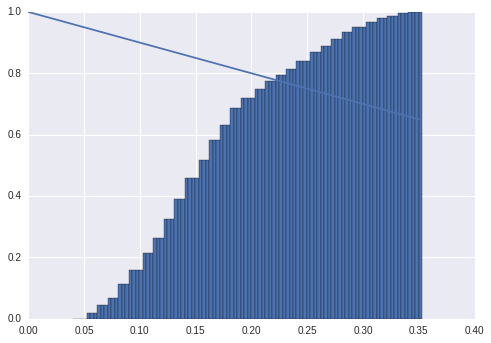

In [44]:
print stat_index(df.Magnitude,frame,frame)

100 0.18
0.333333333333
1.85185185185


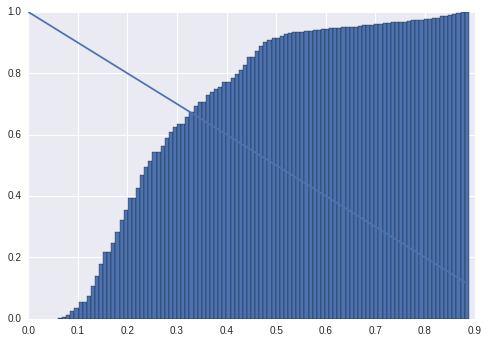

In [45]:
print stat_index(df.logtime,frame,frame)

In [46]:
frame=150

150 0.16
0.240447427293
1.50279642058


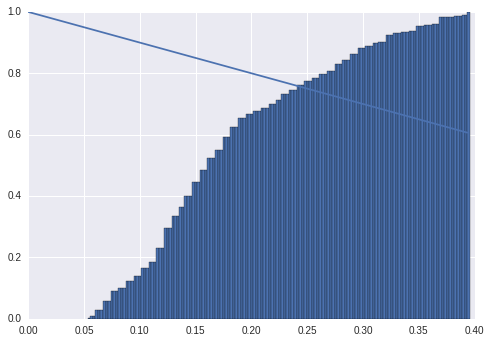

In [47]:
print stat_index(df.Depth,frame,frame)

150 0.16
0.200715883669
1.25447427293


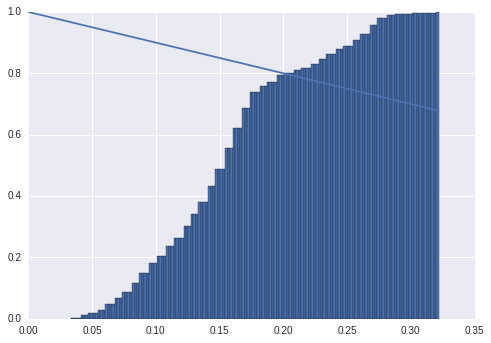

In [48]:
print stat_index(df.Magnitude,frame,frame)

150 0.16
0.35355704698
2.20973154362


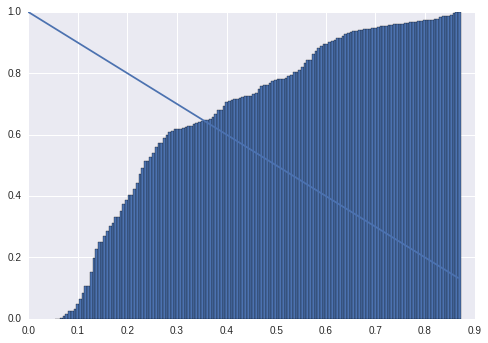

In [49]:
print stat_index(df.logtime,frame,frame)

In [50]:
frame=200

200 0.14
0.241231155779
1.72307968413


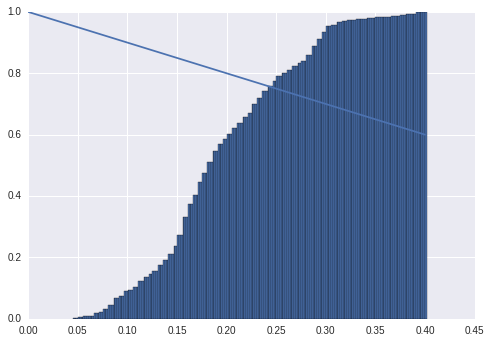

In [51]:
print stat_index(df.Depth,frame,frame)

200 0.14
0.205125628141
1.46518305815


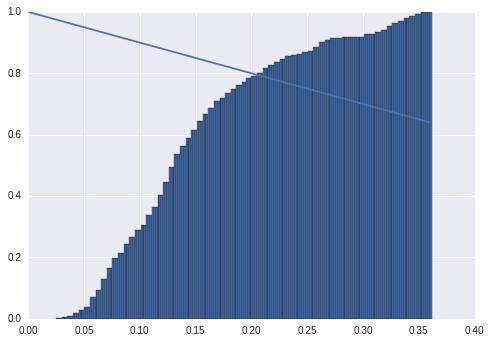

In [52]:
print stat_index(df.Magnitude,frame,frame)

200 0.14
0.399070351759
2.85050251256


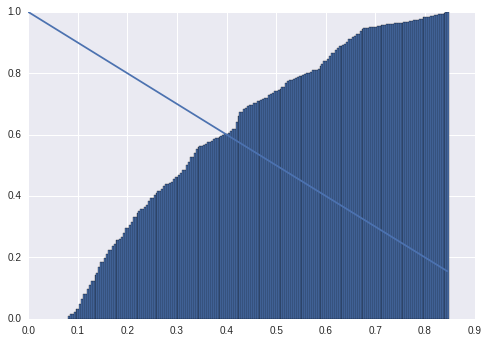

In [53]:
print stat_index(df.logtime,frame,frame)